In [4]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from usa import state_abbreviation_to_name
# from usa import state_name_to_abbreviation
import geopandas as gpd
from matplotlib.colors import ListedColormap
import openpyxl

# MEI V2 Data

In [6]:
url = "https://www.psl.noaa.gov/enso/mei/data/meiv2.data"
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Save the data to a file
    with open('../../Data/meiv2.data', 'w') as file:
        file.write(response.text)
else:
    print("Failed to retrieve data")

In [8]:

# Read the data into a DataFrame, delim tab, no header, last lines delete, skip first line
enso_mei = pd.read_csv('../../Data/meiv2.data', delim_whitespace=True, header=None, skipfooter=3, engine='python', skiprows=1)
#Set first column as index as year, remove 0 column index
enso_mei = enso_mei.set_index(0)
enso_mei.index.name = None

#Set column names as bi monthly periods (Dec/Jan, Jan/Feb, etc)
enso_mei.columns = ['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov']

#Remove last row and all -999.00 values
enso_mei = enso_mei.iloc[:-1]
enso_mei = enso_mei.replace(-999.00, None)
#Row index to YYYY format
enso_mei.index = pd.to_datetime(enso_mei.index, format='%Y')

display(enso_mei.head())

,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov
1979-01-01,0.47,0.27,-0.04,0.26,0.35,-0.14,-0.13,0.50,0.42,0.28,0.58,0.68
1980-01-01,0.42,0.30,0.52,0.85,0.71,0.55,0.52,0.13,0.19,0.06,-0.09,-0.09
1981-01-01,-0.28,-0.19,0.16,0.15,-0.38,-0.63,-0.51,-0.25,0.03,-0.05,-0.16,-0.18
1982-01-01,-0.44,-0.61,-0.31,0.13,0.66,1.42,1.87,1.93,1.74,1.87,2.25,2.45
1983-01-01,2.59,2.73,2.71,2.74,2.60,1.58,0.88,0.03,-0.41,-0.44,-0.42,-0.44


## Create timeseries with date

In [ ]:
#Reformat data to have one column for year, one column for month, and one column for MEI value
#Create empty dataframe
enso_mei_long = pd.DataFrame()
#Create empty list for year, month, and mei values
year = []
month = []
mei = []
#Loop through each row in the dataframe
for index, row in enso_mei.iterrows():
    #Loop through each column in the dataframe
    for column in enso_mei.columns:
        #Append the year, month, and mei value to the corresponding list
        year.append(index.year)
        month.append(column)
        mei.append(row[column])
#Add the lists to the dataframe
enso_mei_long['Year'] = year
enso_mei_long['Month'] = month
enso_mei_long['MEI'] = mei
#Set the index as the year and month
enso_mei_long = enso_mei_long.set_index(['Year', 'Month'])
display(enso_mei_long.head(20))
#Save CSV file
enso_mei_long.to_csv('../Data/enso_mei_long.csv')



MEI
Year Month      
1979 Dec    0.47
     Jan    0.27
     Feb   -0.04
     Mar    0.26
     Apr    0.35
     May   -0.14
     Jun   -0.13
     Jul    0.50
     Aug    0.42
     Sep    0.28
     Oct    0.58
     Nov    0.68
1980 Dec    0.42
     Jan    0.30
     Feb    0.52
     Mar    0.85
     Apr    0.71
     May    0.55
     Jun    0.52
     Jul    0.13

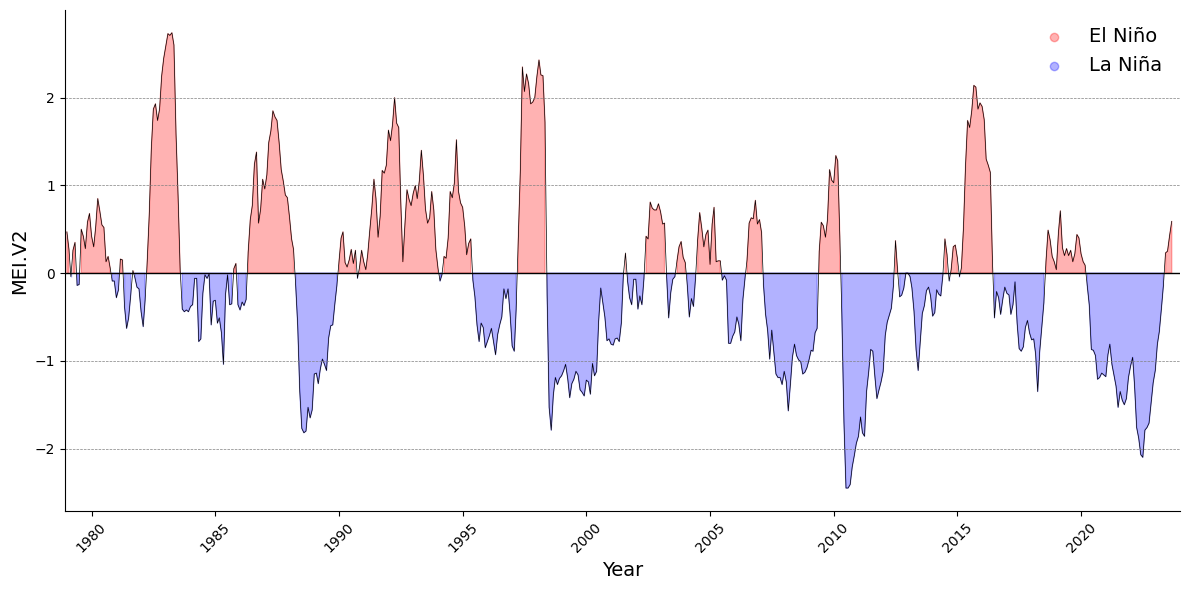

In [18]:
enso_mei_long = pd.read_csv('../../Data/enso_mei_long.csv')
# Combine the Year and Month columns to create a new Date column
enso_mei_long['Date'] = enso_mei_long['Year'].astype(str) + '-' + enso_mei_long['Month']
# Convert the new Date column to datetime format
enso_mei_long['Date'] = pd.to_datetime(enso_mei_long['Date'], format='%Y-%b')
#Plot the data
plt.figure(figsize=(12, 6))
plt.plot(enso_mei_long['Date'], enso_mei_long['MEI'], linestyle='-', color='black', linewidth=0.5)
#Only plot until 2024 x axis
plt.xlim(pd.Timestamp('1978-12-01'), pd.Timestamp('2024-01-01'))

plt.xlabel('Year', fontsize=14)
plt.ylabel('MEI.V2', fontsize=14)
#Create title, big font, bold
# plt.title('ENSO MEI Values Over Time', fontsize=16, fontweight='bold')
plt.grid(False)
#Create dotted lines for El Nino and La Nina thresholds
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-2, color='gray', linestyle='--', linewidth=0.5)
#remove top and right spine
sns.despine()


#grey background between 1 and -1
plt.axhspan(-1, 1, facecolor='white', alpha=0.2)
#Create thick solid line through 0
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
#Fill line above 0 with light red  
plt.fill_between(enso_mei_long['Date'], enso_mei_long['MEI'], where=enso_mei_long['MEI'] >= 0, color='red', alpha=0.3)
#Fill line below 0 with light blue
plt.fill_between(enso_mei_long['Date'], enso_mei_long['MEI'], where=enso_mei_long['MEI'] <= 0, color='blue', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
# Adding a legend for El Niño and La Niña
plt.scatter([], [], c='red', alpha=0.3, label="El Niño")
plt.scatter([], [], c='blue', alpha=0.3, label="La Niña")
plt.legend(loc="upper right", frameon=False, fontsize=14)
#Save plot in Plots folder with full quality
plt.savefig('../../Plots/enso_mei_long.png', dpi=300)

## Highlight El Niño highest cases

In [10]:
#Highlight El Nino and La Nina periods
#Create empty list for El Nino and La Nina periods
el_nino = []
la_nina = []
#Loop through each row in the dataframe
for index, row in enso_mei_long.iterrows():
    #If MEI value is greater than 1, append the date to the El Nino list
    if row['MEI'] > 1:
        el_nino.append(enso_mei_long.loc[index, 'Date'])
    #If MEI value is less than -1, append the date to the La Nina list
    elif row['MEI'] < -1:
        la_nina.append(enso_mei_long.loc[index, 'Date'])
#Create a dataframe for El Nino and La Nina periods
el_nino = pd.DataFrame(el_nino, columns=['Date'])
la_nina = pd.DataFrame(la_nina, columns=['Date'])
#From data collect years which have continuous el nino or la nina periods
el_nino['Year'] = el_nino['Date'].dt.year
la_nina['Year'] = la_nina['Date'].dt.year
#Group by year and count the number of El Nino and La Nina periods
el_nino_grouped = el_nino.groupby('Year').count()
la_nina_grouped = la_nina.groupby('Year').count()

#display(el_nino, el_nino_grouped)